In [26]:
import os
import sys
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from scipy import signal
import scipy

%matplotlib inline

In [2]:
# database full path
database_name = 'whistlers.h5'
database_location = os.path.join(os.getcwd().split(os.environ.get('USER'))[0],os.environ.get('USER'), 'wdml', 'Data')
database_path = os.path.join(database_location,database_name)

# data variables
awd_events = 2
sites = ['marion', 'sanae']

In [39]:
def scale_to_extreme(arr, thr):
    arr = np.asarray(arr)
    arr_min = arr.min()
    arr_max = arr.max()
    _arr = [arr_min if a < thr else arr_max for a in arr]
    return _arr

In [3]:
def extract_spectrogram_info(spectrogram_data):
    '''Extract the time, frequency axis values as well as the 
            spectrogram data.
    inputs:
        spectrogram_data: the spectrogram data including the 
        time and frequency information.
    outputs: 
        time: time values
        frequency: frequency values
        spectrogram: spectrogram
    '''
    time = spectrogram_data[0,1:]
    frequency = spectrogram_data[1:,0]
    spectrogram = spectrogram_data[1:,1:]
    return time, frequency, spectrogram

In [59]:
f  = h5py.File(database_path, 'r')
grp_wh = f[os.path.join('awdEvents'+str(1), sites[0],'whistler traces')]
files = list(grp_wh.keys())
file = files[np.random.randint(len(files))] # select a random sample
# create np array to store sample information
whdf = np.empty(grp_wh[file].shape)
grp_wh[file].read_direct(whdf)
fs = grp_wh[file].attrs['sample frequency']
f.close()
# get spectrogram
f, t, Sxx = signal.spectrogram(whdf[:,0], fs=fs, detrend='linear', nfft=512 , noverlap=64, scaling='spectrum',mode='psd')
Sxx_psd = np.log10(Sxx)
# get mean
mean = np.mean(Sxx_psd)
std = np.std(Sxx_psd)
print('Mean of PSD: ', mean)
print('Standard deviation of PSD: ', std)
print(Sxx_psd.max(), Sxx_psd.min())

Mean of PSD:  3.40862594792205
Standard deviation of PSD:  0.8861035815235087
6.7386116721494655 -3.0956546985878055


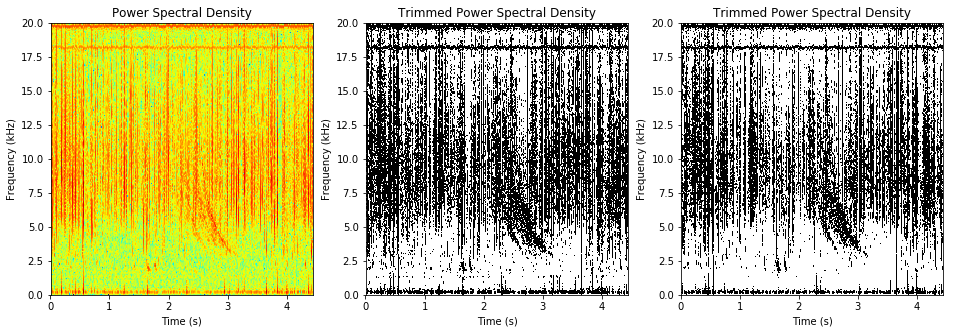

In [65]:
# plot 
plt.figure(figsize=(16,5))
fig = plt.subplot(1,3,1)
img = plt.pcolormesh(t,f/1000,Sxx_psd, cmap='jet')
# fig.colorbar(mappable=img, label='Power [dB]')
plt.title('Power Spectral Density')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')

Sxx_psd_trm = np.reshape(scale_to_extreme(Sxx_psd.flatten(), mean),Sxx_psd.shape)
fig = plt.subplot(1,3,2)
img = plt.pcolormesh(t,f/1000, Sxx_psd_trm, cmap='binary')
# fig.colorbar(mappable=img, label='Power [dB]')
plt.title('Trimmed Power Spectral Density')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')

Sxx_psd_trm_std = np.reshape(scale_to_extreme(Sxx_psd.flatten(), mean+0.2*std),Sxx_psd.shape)
fig = plt.subplot(1,3,3)
img = plt.pcolormesh(t,f/1000, Sxx_psd_trm_std, cmap='binary')
# fig.colorbar(mappable=img, label='Power [dB]')
plt.title('Trimmed Power Spectral Density')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.show()

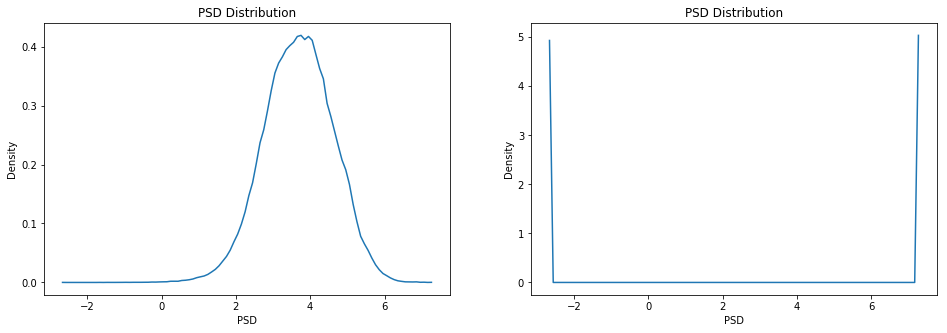

In [49]:
Sxx_psd_flat = Sxx_psd.flatten()
Sxx_psd_trm_flat = Sxx_psd_trm.flatten()

plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
(n, bins) = np.histogram(Sxx_psd_flat, bins=100, density=True)  # NumPy version (no plot)
plt.plot(.5*(bins[1:]+bins[:-1]), n)
plt.title('PSD Distribution')
plt.xlabel('PSD')
plt.ylabel('Density')
plt.subplot(1,2,2)
(n, bins) = np.histogram(Sxx_psd_trm_flat, bins=100, density=True)  # NumPy version (no plot)
plt.plot(.5*(bins[1:]+bins[:-1]), n)
plt.title('PSD Distribution')
plt.xlabel('PSD')
plt.ylabel('Density')
plt.show()